In [88]:
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm
from transformers import logging as transformer_logging
transformer_logging.set_verbosity_error()

rand_ins = [
    'app store',
    'google play',
    'burger king',
#     'macdonalds',
#     'rostics',
#     'kfc',
    'ресторан стоит',
    'телефон работает',
    'еду кушают',
    'ночью спят',
    'днем работают',
    'обед днем',
    'завтрак утром',
    'ужин вечером'
]

def random_insert2str(s0):
    
    s = s0.strip()
    spaces = [i for i, ltr in enumerate(s) if ltr == ' ']
    inserts = []
    if len(spaces) > 0:
        inserts=np.random.choice(rand_ins, len(spaces)//5 + 1)
    else:
        return s + ' ' + np.random.choice(rand_ins, 1)[0]

    spaces2ins = np.random.choice(spaces, len(inserts))

    ss = ''
    i0 = 0
    for ind, i in enumerate(spaces2ins):
        ss += s[i0:i] + f' {inserts[ind]}'
        i0 = i
    if i0 < len(s):
        ss += s[i0:]
    return ss

class CustomModel(nn.Module):
    def __init__(self, checkpoint, num_labels, out_features=768):
        super(CustomModel,self).__init__()
        self.num_labels = num_labels

        #Load Model with given checkpoint and extract its body
        self.model = AutoModel.from_pretrained(checkpoint,
                                                config=AutoConfig.from_pretrained(checkpoint, 
                                                                                 output_attentions=True,
                                                                                 output_hidden_states=True))
        
        self.out_features = out_features#model.encoder.layer[1].output.dense.out_features
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.out_features, num_labels) # load and initialize weights

    def forward(self, input_ids=None, attention_mask=None,labels=None):
        #Extract outputs from the body
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        #Add custom layers
        sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state
        
        logits = self.classifier(sequence_output[:,0,:].view(-1,self.out_features)) # calculate losses

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()

            loss = loss_fct(logits.view(-1, self.num_labels), labels.float().view(-1, self.num_labels))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)


In [95]:
def classify_w_custom_bert(checkpoint, text_var_name = 'content', out_features=312, random_insert=False, num_epochs = 3):
    
    BATCH_SIZE = 8
    seq_len = 512
    n_classes = len(idx2cls.items())

    t = pd.read_excel(f'{sdir}t4m_2022_05_05__21_59.xlsx')
    
    df = t[['content', 'text', 'class_name']].copy()
    df['label'] = df['class_name'].map(cls2idx)
    class_names_list = df['class_name'].values.tolist()

    tmp = df[['content', 'text','label']].assign(p=1).\
        pivot_table(index=['content', 'text'], columns='label', values='p').fillna(0).astype(int).reset_index()

    cols = [i for i in range(len(idx2cls.items()))]

    tmp['target'] = tmp.apply(lambda row: list(row[cols]), axis=1)
    tmp = tmp[['content', 'text', 'target']].copy()
    data = tmp.copy()

    data = data[[text_var_name, 'target']].set_axis(['headline', 'label'], axis=1)
    data['class_name'] = class_names_list
    data=Dataset.from_pandas(data)

    # 80% train, 20% test + validation
    train_testvalid = data.train_test_split(test_size=0.3,seed=15)

    # Split the 10% test + valid in half test, half valid
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5,seed=15)

    # gather everything to have a single DatasetDict
    data = DatasetDict({
        'train': train_testvalid['train'],
        'test': test_valid['test'],
        'valid': test_valid['train'],
                       })
    
    
    ###############
    if random_insert:
        Xy = data['train'].to_pandas()
        target = 'headline'

        cnts = pd.DataFrame(Xy['class_name'].value_counts()).reset_index().set_axis(['cname', 'cnt'], axis=1).\
            assign(needed=lambda row: row['cnt'].max()-row['cnt'])

        rows2add = []
        for ind, row in cnts.iterrows():
            cname = row['cname']
            smpl = Xy.query(f'class_name == @cname').sample(row['needed'], replace=True)
            for ind2, row2 in smpl.iterrows():
                rows2add.append([random_insert2str(row2[target]), row2['label'], row2['class_name']])

        Xy = pd.concat([Xy, pd.DataFrame(rows2add, columns = Xy.columns)]).sample(frac=1)

        data['train'] = Dataset.from_pandas(Xy)
    
    ###############
    

    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    tokenizer.model_max_len=seq_len


    def tokenize(batch):
        return tokenizer(batch["headline"], truncation=True,max_length=seq_len)
    tokenized_dataset = data.map(tokenize, batched=True)

    tokenized_dataset.set_format("torch",columns=["input_ids", "attention_mask", "label"])
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    model = CustomModel(checkpoint=checkpoint, num_labels=n_classes, out_features=out_features).to(device)

    train_dataloader = DataLoader(
        tokenized_dataset["train"], shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator
    )
    eval_dataloader = DataLoader(
        tokenized_dataset["valid"], batch_size=BATCH_SIZE, collate_fn=data_collator
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     num_epochs = 3
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    metric = load_metric("f1")

    progress_bar_train = tqdm(range(num_training_steps))
    progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))


    losses = []
    for epoch in range(num_epochs):
        model.train()
        curlosses_train = []
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar_train.update(1)
            
            curlosses_train.append(loss.item())

        model.eval()
        curlosses_test = []
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            targets = torch.argmax(batch["labels"], dim=-1)
            metric.add_batch(predictions=predictions, references=targets)
            progress_bar_eval.update(1)
            
            curlosses_test.append(loss.item())
            
        f1 = metric.compute(average='macro')
#         print(f1)
        losses.append([epoch+1, np.mean(np.array(curlosses_train)), np.mean(np.array(curlosses_test)), f1['f1']])



    losses = pd.DataFrame(losses, columns=['epoch', 'loss_train', 'loss_val', 'f1'])
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(121)
    plt.plot(losses['epoch'], losses['loss_train'], '-o')
    plt.plot(losses['epoch'], losses['loss_val'], '-o')
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.legend(['train loss', 'val loss'])
    plt.title('Loss - epoch dependency')
    
    
    plt.subplot(122)
    plt.plot(losses['epoch'], losses['f1'], '-o')
    
    plt.xlabel('epoch')
    plt.ylabel('F1')
    plt.title('F1 score - epoch dependency')
        
    plt.show()
        
    torch.save(model, 'bert_model_v1.pt')
    
    ### test

    metric = load_metric("f1")

    model.eval()

    test_dataloader = DataLoader(
        tokenized_dataset["test"], batch_size=BATCH_SIZE, collate_fn=data_collator
    )

    preds = []
    labs = []
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits

        predictions = torch.argmax(logits, dim=-1)
        targets = torch.argmax(batch["labels"], dim=-1)
        metric.add_batch(predictions=predictions, references=targets)

        preds += list(torch.argmax(logits, dim=-1).detach().cpu().numpy())
        labs += list(torch.argmax(batch["labels"], dim=-1).detach().cpu().numpy())

    print(metric.compute(average='macro'))

    test = tokenized_dataset["test"].to_pandas()
    test['preds'] = preds
    test['true'] = labs


    print(30* '#')
    print(f'text_var_name = {text_var_name}, checkpoint = {checkpoint}')
    print()
    print(classification_report(test['true'], test['preds'], target_names=[v.replace('_', ' ') for i,v in idx2cls.items()]))

Map:   0%|          | 0/2224 [00:00<?, ? examples/s]

Map:   0%|          | 0/477 [00:00<?, ? examples/s]

Map:   0%|          | 0/477 [00:00<?, ? examples/s]

  0%|          | 0/1668 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

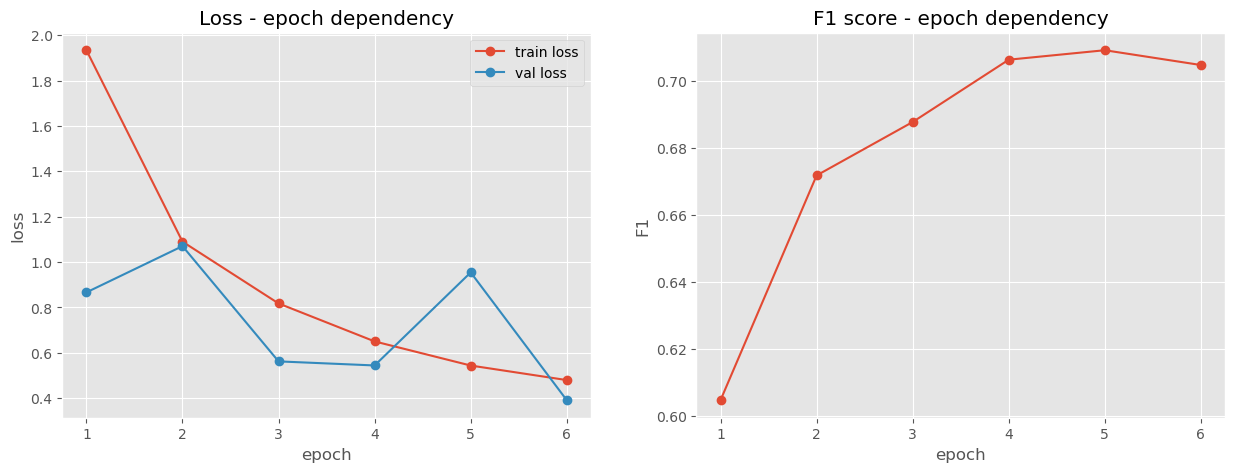

{'f1': 0.6473800703237799}
##############################
text_var_name = content, checkpoint = cointegrated/rubert-tiny2

                                           precision    recall  f1-score   support

                                     uxui       0.57      0.62      0.59        34
                                   другое       0.62      0.76      0.68        37
                                  аккаунт       0.65      0.85      0.74        20
                                   оплата       0.73      0.81      0.77        37
                               обновление       0.65      0.60      0.63        25
                           доставка общее       0.73      0.77      0.75        39
                               лояльность       0.85      0.87      0.86        47
                                   купоны       0.81      0.66      0.72        32
не возвращаются деньги отмененного заказа       0.38      0.64      0.47        14
                          создание заказа     

Map:   0%|          | 0/2224 [00:00<?, ? examples/s]

Map:   0%|          | 0/477 [00:00<?, ? examples/s]

Map:   0%|          | 0/477 [00:00<?, ? examples/s]

  0%|          | 0/1668 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

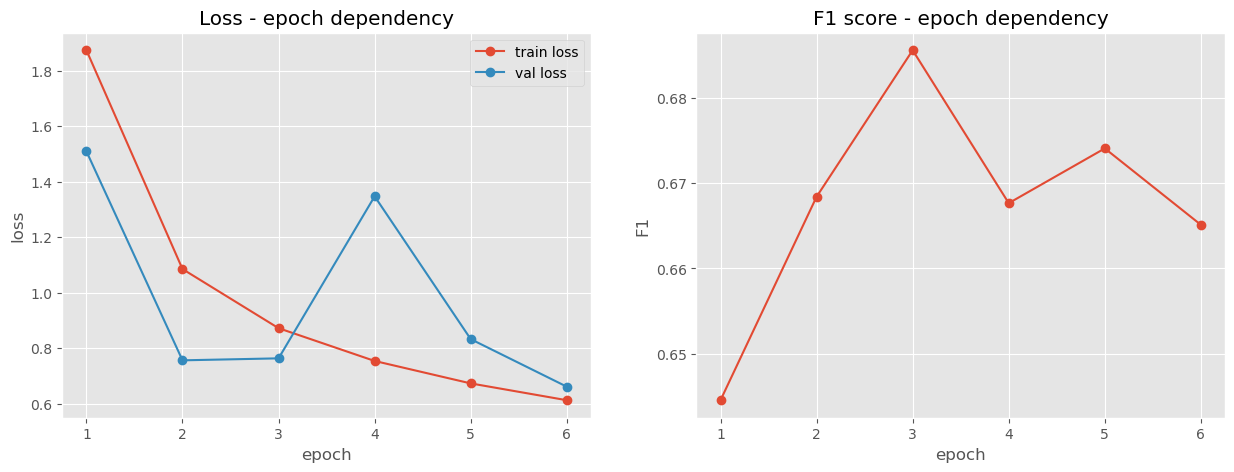

{'f1': 0.6746211331214212}
##############################
text_var_name = text, checkpoint = cointegrated/rubert-tiny2

                                           precision    recall  f1-score   support

                                     uxui       0.47      0.68      0.55        34
                                   другое       0.60      0.73      0.66        37
                                  аккаунт       0.71      0.75      0.73        20
                                   оплата       0.68      0.76      0.72        37
                               обновление       0.71      0.80      0.75        25
                           доставка общее       0.64      0.74      0.69        39
                               лояльность       0.82      0.87      0.85        47
                                   купоны       0.90      0.81      0.85        32
не возвращаются деньги отмененного заказа       0.53      0.57      0.55        14
                          создание заказа       0

In [96]:
checkpoint = 'cointegrated/rubert-tiny2'
classify_w_custom_bert(checkpoint, text_var_name = 'content', out_features=312, num_epochs=6)
classify_w_custom_bert(checkpoint, text_var_name = 'text', out_features=312, num_epochs=6)


Map:   0%|          | 0/2224 [00:00<?, ? examples/s]

Map:   0%|          | 0/477 [00:00<?, ? examples/s]

Map:   0%|          | 0/477 [00:00<?, ? examples/s]

  0%|          | 0/1668 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

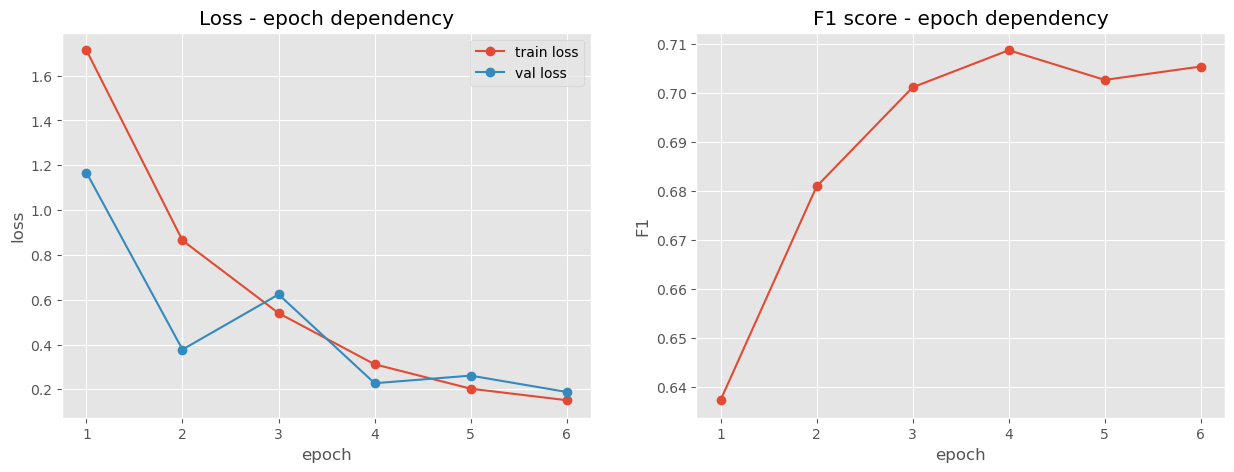

{'f1': 0.6746863133744845}
##############################
text_var_name = content, checkpoint = DeepPavlov/distilrubert-small-cased-conversational

                                           precision    recall  f1-score   support

                                     uxui       0.54      0.65      0.59        34
                                   другое       0.64      0.73      0.68        37
                                  аккаунт       0.65      0.75      0.70        20
                                   оплата       0.81      0.78      0.79        37
                               обновление       0.76      0.64      0.70        25
                           доставка общее       0.70      0.77      0.73        39
                               лояльность       0.82      0.85      0.83        47
                                   купоны       0.86      0.78      0.82        32
не возвращаются деньги отмененного заказа       0.44      0.57      0.50        14
                     

Map:   0%|          | 0/2224 [00:00<?, ? examples/s]

Map:   0%|          | 0/477 [00:00<?, ? examples/s]

Map:   0%|          | 0/477 [00:00<?, ? examples/s]

  0%|          | 0/1668 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

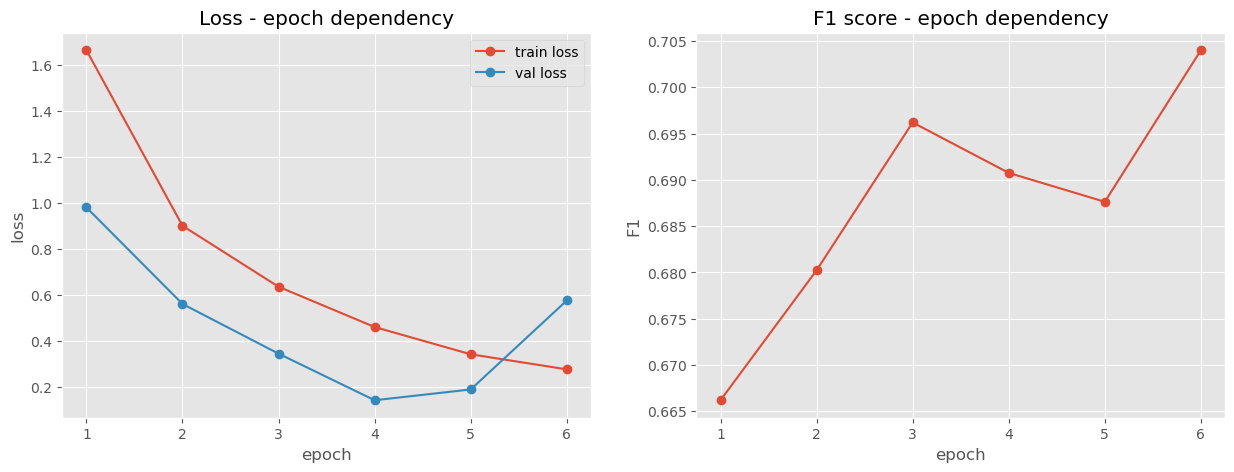

{'f1': 0.6582132824728703}
##############################
text_var_name = text, checkpoint = DeepPavlov/distilrubert-small-cased-conversational

                                           precision    recall  f1-score   support

                                     uxui       0.38      0.53      0.44        34
                                   другое       0.61      0.59      0.60        37
                                  аккаунт       0.70      0.80      0.74        20
                                   оплата       0.76      0.76      0.76        37
                               обновление       0.60      0.60      0.60        25
                           доставка общее       0.70      0.77      0.73        39
                               лояльность       0.89      0.85      0.87        47
                                   купоны       0.86      0.75      0.80        32
не возвращаются деньги отмененного заказа       0.60      0.64      0.62        14
                        

In [97]:
checkpoint = 'DeepPavlov/distilrubert-small-cased-conversational'

classify_w_custom_bert(checkpoint, text_var_name = 'content', out_features=768, num_epochs=6)
classify_w_custom_bert(checkpoint, text_var_name = 'text', out_features=768, num_epochs=6)

Map:   0%|          | 0/2224 [00:00<?, ? examples/s]

Map:   0%|          | 0/477 [00:00<?, ? examples/s]

Map:   0%|          | 0/477 [00:00<?, ? examples/s]

  0%|          | 0/834 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

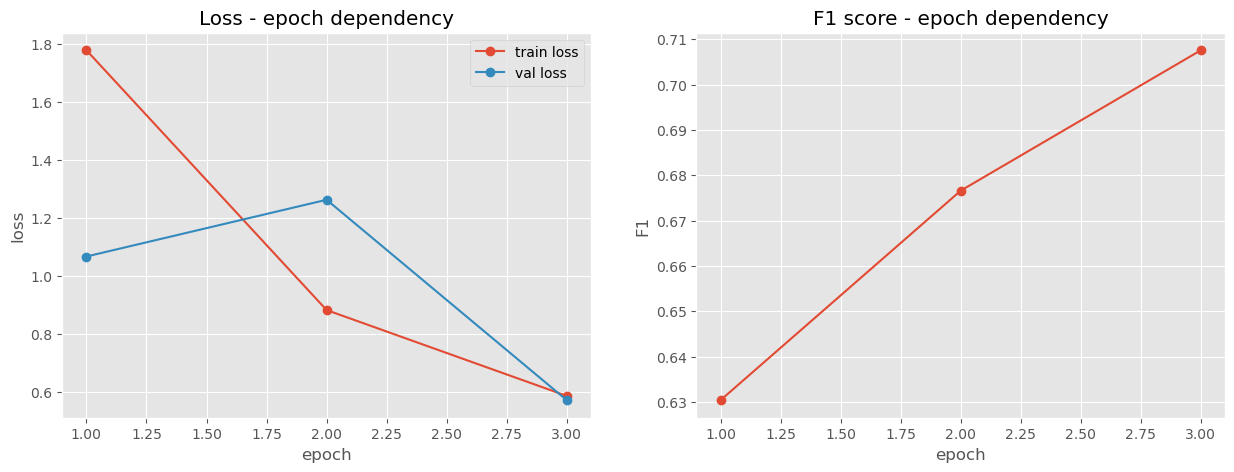

{'f1': 0.6737142248110511}
##############################
text_var_name = content, checkpoint = DeepPavlov/distilrubert-small-cased-conversational

                                           precision    recall  f1-score   support

                                     uxui       0.50      0.74      0.60        34
                                   другое       0.67      0.70      0.68        37
                                  аккаунт       0.67      0.80      0.73        20
                                   оплата       0.82      0.76      0.79        37
                               обновление       0.67      0.64      0.65        25
                           доставка общее       0.70      0.79      0.75        39
                               лояльность       0.86      0.79      0.82        47
                                   купоны       0.93      0.81      0.87        32
не возвращаются деньги отмененного заказа       0.42      0.57      0.48        14
                     

In [99]:
checkpoint = 'DeepPavlov/distilrubert-small-cased-conversational'

classify_w_custom_bert(checkpoint, text_var_name = 'content', out_features=768, num_epochs=3)

In [72]:
n_classes = 15


labs_mc = [[1 if i == j else 0 for i in range(n_classes)] for j in labs]
preds_mc = [[1 if i == j else 0 for i in range(n_classes)] for j in preds]

In [71]:
def pos_recall(true0, pred0):
    r = 0
    for i, v in enumerate(true0):
        if pred0[i] == v : r += 1
        else: r -+ 1
    return r/len(true0)

In [73]:
res = []
for true0, pred0 in zip(labs_mc, preds_mc):
    res.append(pos_recall(true0, pred0))
np.mean(np.array(res))

0.9563941299790356